# Anime-Or-Not

## library import

In [1]:
import kagglehub
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from timeit import default_timer as timer 

import torch
from torch import nn
from torchvision import datasets, transforms, models
from  torch.utils.data import DataLoader, random_split, Dataset
from  torchinfo import summary
import wandb

import random
from PIL import Image


In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## download images

In [3]:
# download latest version data

path = kagglehub.dataset_download("kanakmittal/anime-and-cartoon-image-classification")
print("Path to dataset files:", path)

# then copy the files to the desired location --> ../data/

Path to dataset files: C:\Users\ahnaf\.cache\kagglehub\datasets\kanakmittal\anime-and-cartoon-image-classification\versions\1


now copy the downloaded `Training Data/` to `../data/`

## load images

In [4]:
data_path = Path("../data/")
image_path = data_path / "Training Data"

 # check if the image folder exists
if image_path.is_dir():
    print(f"'{image_path}' directory exists. Good to go.")
else:
    print(f"Did not find '{image_path}' directory, please download the dataset and extract it to the correct location: '{data_path}'")

'..\data\Training Data' directory exists. Good to go.


In [5]:
type(data_path), type(image_path)

(pathlib.WindowsPath, pathlib.WindowsPath)

In [6]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
walk_through_dir(image_path)

There are 2 directories and 0 images in '..\data\Training Data'.
There are 51 directories and 0 images in '..\data\Training Data\Anime'.
There are 0 directories and 66 images in '..\data\Training Data\Anime\Ace of Diamond'.
There are 0 directories and 89 images in '..\data\Training Data\Anime\Akame ga Kill!'.
There are 0 directories and 86 images in '..\data\Training Data\Anime\Angel Beats'.
There are 0 directories and 79 images in '..\data\Training Data\Anime\Anohana The Flower We Saw That Day'.
There are 0 directories and 86 images in '..\data\Training Data\Anime\Attack on Titan'.
There are 0 directories and 89 images in '..\data\Training Data\Anime\Baccano'.
There are 0 directories and 81 images in '..\data\Training Data\Anime\Black Butler'.
There are 0 directories and 90 images in '..\data\Training Data\Anime\Black Cat'.
There are 0 directories and 87 images in '..\data\Training Data\Anime\Black Lagoon'.
There are 0 directories and 80 images in '..\data\Training Data\Anime\Bleach'.

### Visualize an image

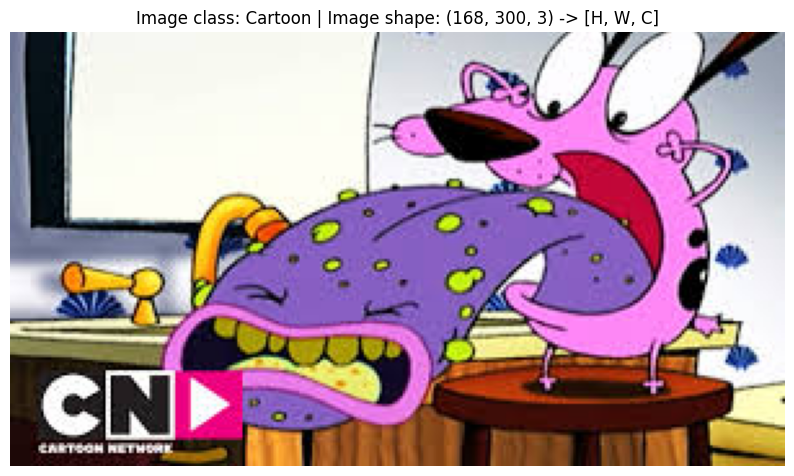

In [8]:
random.seed(150)

image_path_list = list(image_path.glob("**/*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.parent.name

img = Image.open(random_image_path)

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [H, W, C]")
plt.axis(False);

## load images into pytorch

before we can use our image data with pytorch we need to:

- turn it into `tensors` (numerical representations of our images)
- turn it into a `torch.utils.data.Dataset` and subsequently a `torch.util.data.DataLoader`

### transform

In [9]:
# Define transformations (resize, normalize, convert to tensor)

img_resize = (224, 224) # Resize images to 224x224 for ResNet

train_data_transform = transforms.Compose([
    transforms.Resize(img_resize),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.RandomRotation(degrees=(-30, 30))], p=0.5),
    transforms.ToTensor(),  # Convert to tensor
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # TODO: how to set these values?
]) # TODO: try with different transformations

test_data_transform = transforms.Compose([
    transforms.Resize(img_resize),
    transforms.ToTensor(),  # Convert to tensor
])

In [10]:
# Define a wrapper to apply different transforms, use separate transforms for training and testing
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.dataset = subset.dataset
        self.indices = subset.indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]  # Get image & label
        img = self.transform(img)  # Apply transform
        return img, label


with this composition of transforms, let's try them out on various images:

In [11]:
def plot_transformed_images(image_paths, transform, n=3, seed=150):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 150.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.parent.stem}", fontsize=16)

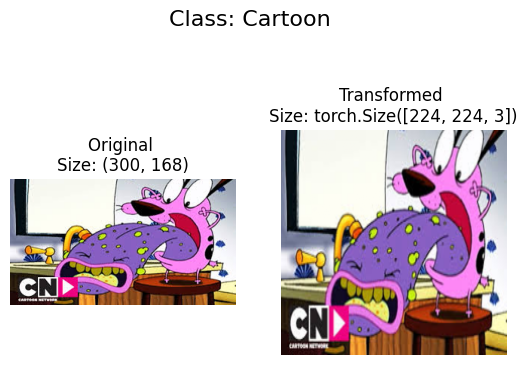

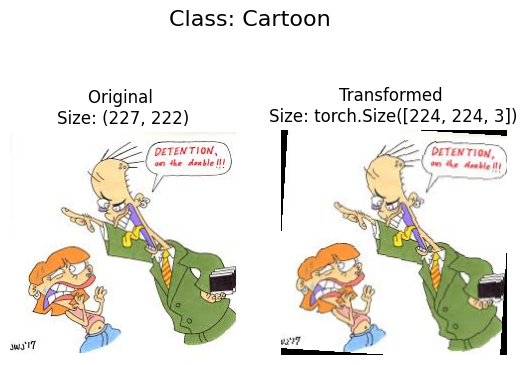

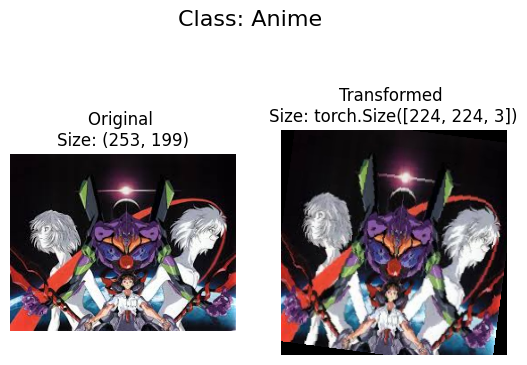

In [12]:
image_path_list = list(image_path.glob("**/*.jpg"))
plot_transformed_images(image_path_list, transform=train_data_transform, n=3)

### load dataset

In [13]:
# Load dataset
# dataset = datasets.ImageFolder(root=image_path, transform=train_data_transform)
dataset = datasets.ImageFolder(root=image_path) # no transform applied

In [14]:
dataset

Dataset ImageFolder
    Number of datapoints: 8892
    Root location: ..\data\Training Data

### train-test split

In [15]:
# Split into train & test
train_size = int(0.8 * len(dataset))  # 80% train, 20% test
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

In [16]:
train_data, test_data

(<torch.utils.data.dataset.Subset at 0x118de7746d0>,
 <torch.utils.data.dataset.Subset at 0x118de774b80>)

In [17]:
# Apply different transforms
train_data = TransformedDataset(train_data, train_data_transform)
test_data = TransformedDataset(test_data, test_data_transform)

In [18]:
train_data, test_data

(<__main__.TransformedDataset at 0x118de774880>,
 <__main__.TransformedDataset at 0x118de774a30>)

In [19]:
print(f"Train data:\nDataset size: {len(train_data)}\nTransform: {train_data.transform}\n")
print(f"Test data:\nDataset size: {len(test_data)}\nTransform: {test_data.transform}")


Train data:
Dataset size: 7113
Transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomApply(
    p=0.5
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
)
    ToTensor()
)

Test data:
Dataset size: 1779
Transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [20]:
class_names = dataset.classes
class_names

['Anime', 'Cartoon']

In [21]:
class_dict = dataset.class_to_idx
class_dict

{'Anime': 0, 'Cartoon': 1}

In [22]:
len(train_data), len(test_data)

(7113, 1779)

can index `train_data`, `test_data` to find samples and their target labels

In [23]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.4588, 0.5020, 0.5373,  ..., 0.6667, 0.6039, 0.6392],
         [0.0235, 0.0275, 0.0431,  ..., 0.1490, 0.0706, 0.0784],
         [0.1059, 0.1255, 0.1412,  ..., 0.3137, 0.2235, 0.2510],
         ...,
         [0.9961, 0.9922, 0.9961,  ..., 0.5412, 0.8667, 0.9569],
         [0.9529, 0.9490, 0.9529,  ..., 0.3569, 0.4392, 0.5647],
         [0.8392, 0.8392, 0.8392,  ..., 0.8980, 0.9294, 0.9373]],

        [[0.7647, 0.7961, 0.8078,  ..., 0.6431, 0.5804, 0.6196],
         [0.3059, 0.3216, 0.3176,  ..., 0.1216, 0.0431, 0.0471],
         [0.4196, 0.4235, 0.4196,  ..., 0.2588, 0.1686, 0.1961],
         ...,
         [0.9882, 0.9922, 0.9843,  ..., 0.4039, 0.7333, 0.8588],
         [0.9490, 0.9490, 0.9451,  ..., 0.2353, 0.3255, 0.4471],
         [0.8392, 0.8392, 0.8353,  ..., 0.7961, 0.8235, 0.8314]],

        [[0.5098, 0.5412, 0.5490,  ..., 0.5137, 0.4784, 0.5412],
         [0.0510, 0.0667, 0.0588,  ..., 0.0314, 0.0275, 0.0275],
         [0.1647, 0.1725, 0.1686,  ..., 0.10

now can plot image tensors as well

Original shape: torch.Size([3, 224, 224]) -> [C, H, W]
Image permute shape: torch.Size([3, 224, 224]) -> [H, W, C]


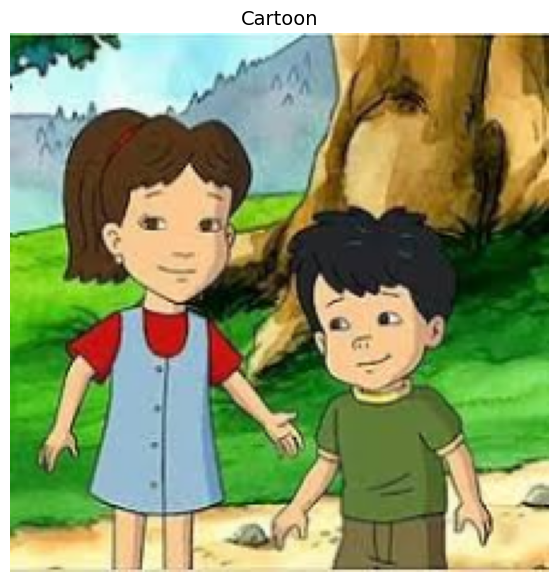

In [24]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [C, H, W]")
print(f"Image permute shape: {img.shape} -> [H, W, C]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [25]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: Dataset,
                          classes: list[str] | None = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int | None = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

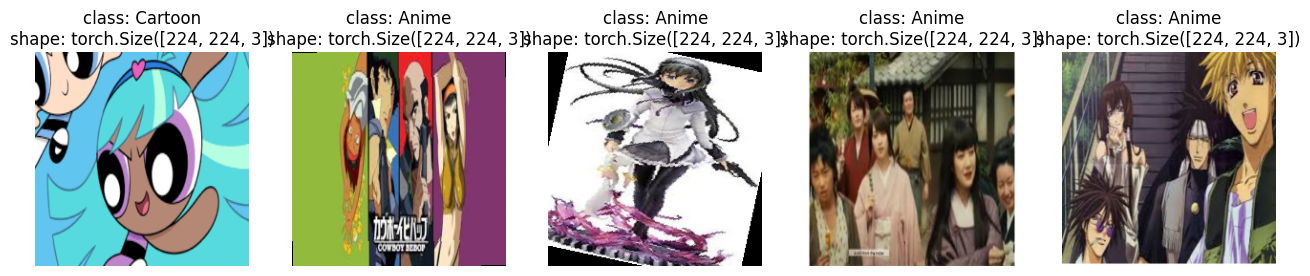

In [26]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

### dataloaders

Turning our `Dataset`'s into `DataLoader`'s makes them iterable so a model can go through and learn the relationships between samples and targets (features and labels).

In [27]:
os.cpu_count()

12

In [28]:
# Try loading a single sample without DataLoader
img, label = train_data[0]  # Fetch first sample manually
print(f"Single image type: {type(img)}")  # Should be a torch.Tensor
print(f"Single image shape: {img.shape}")  # Should be [C, H, W]
print(f"Label: {label}")


Single image type: <class 'torch.Tensor'>
Single image shape: torch.Size([3, 224, 224])
Label: 1


In [29]:
# train_dataloader = DataLoader(
#     dataset=train_data, 
#     batch_size=32,  # Start with a small batch
#     num_workers=1,  # Avoid multiprocessing issues for now
#     shuffle=True, 
#     pin_memory=True
# )

# img_batch, label_batch = next(iter(train_dataloader))  # Try fetching a batch
# print(f"Batch Image shape: {img_batch.shape}")  # Should be [batch_size, C, H, W]
# print(f"Batch Label shape: {label_batch.shape}")  # Should be [batch_size]


In [30]:
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=32, # how many samples per batch?
                              num_workers=0, # number of processes to use, 0 as its showing issues
                              shuffle=True, # shuffle the data?
                              pin_memory=True # copy Tensors into CUDA pinned memory before returning them?
                            )

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=32, 
                             num_workers=0, 
                             shuffle=False, # don't usually need to shuffle testing data) 
                             pin_memory=True
                            )
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1189164b6a0>,
 <torch.utils.data.dataloader.DataLoader at 0x11891057d00>)

In [31]:
img_batch, label_batch = next(iter(train_dataloader))  # Try fetching a batch
print(f"Batch Image shape: {img_batch.shape}")  # Should be [batch_size, C, H, W]
print(f"Batch Label shape: {label_batch.shape}")  # Should be [batch_size]

Batch Image shape: torch.Size([32, 3, 224, 224])
Batch Label shape: torch.Size([32])


## model

### download & load the pretrained model: ResNet50

- load model's DEFAULT weights (best available weights)
- initiate the model with pre trained weights

In [32]:
# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = models.ResNet50_Weights.DEFAULT # .DEFAULT = best available weights 
model = models.resnet50(weights=weights).to(device)

### freeze classifier layer: fc layer

model summary: before freezing fc layer

In [33]:
# Print model summary
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [34]:
for param in model.parameters():
    param.requires_grad = False
model.fc.requires_grad_(True)

Linear(in_features=2048, out_features=1000, bias=True)

model summary: after freezing fc layer

In [35]:
# Print model summary
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

### updating fc layer as per classification need

In [36]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape= len(class_names)

model.fc = torch.nn.Linear(
    in_features=model.fc.in_features,
    out_features=len(class_names),
    bias=True
    ).to(device)

In [37]:
# Do a summary *after* freezing the features and changing the output classifier layer
summary(model, 
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

### single batch input output test

try to pass single image and get prediction before training

In [38]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred = model(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 224, 224])

Output logits:
tensor([[-0.1335, -0.0858]], device='cuda:0')

Output prediction probabilities:
tensor([[0.4881, 0.5119]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
1


## train setup

- train_step
- test_step
- train --> train_step + test_step
- seed
- loss function and optimizer
- model

then its ready to begin training!

### train_step

In [39]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

### test_step

In [40]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### train

In [41]:
# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### seed

In [ ]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

### loss function & optimizer

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## model training

In [ ]:
# Set number of epochs
NUM_EPOCHS = 2

# Start the timer
start_time = timer()

# Train model 
model_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

## loss curves

In [ ]:
# Check the model_results keys
model_results.keys()

In [47]:
def plot_loss_curves(results: dict[str, list[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [ ]:
plot_loss_curves(model_results)

## export model

In [ ]:
# uncomment to use
# torch.save(model.state_dict(), "../models/model.pth")

## model tracking with wandb

In [42]:
# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          wandb_log: bool = False):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)
        
        # Log results to wandb
        if wandb_log:
            wandb.log(
                {
                    "epoch": epoch,
                    "train_loss": train_loss,
                    "train_acc": train_acc,
                    "test_loss": test_loss,
                    "test_acc": test_acc
                }
            )
            
    if wandb_log:        
        wandb.finish()
    
    # 6. Return the filled results at the end of the epochs
    return results

In [43]:
def train_wandb(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    wandb_run_name: str,
    loss_fn: torch.nn.Module,
    n_epochs: int = 5,
    wandb_project_name: str = "anime-or-not",
    wandb_log: bool = True,
    config: dict = {"config":'empty'} # Pass in a dictionary of configuration for wandb
):
    # Initialize wandb
    if wandb_log:
        wandb.init(project=wandb_project_name, name=wandb_run_name)
        wandb.watch(model, log="all")
        wandb.config = {**config}

    # Start the timer
    start_time = timer()

    # Train model 
    model_results = train(model=model, 
                            train_dataloader=train_dataloader,
                            test_dataloader=test_dataloader,
                            optimizer=optimizer,
                            loss_fn=loss_fn, 
                            epochs=n_epochs,
                            wandb_log=wandb_log)

    # End the timer and print out how long it took
    end_time = timer()
    print(f"Total training time: {end_time-start_time:.3f} seconds")
    
    return model_results

### run1

In [ ]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

lr= 0.001
n_epochs = 20

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

config= {
    "model": "ResNet50-v0",
    "pretrained": "imagenet",
    "optimizer": "Adam",
    "learning_rate": lr,
    "epochs": n_epochs
}

model_results = train_wandb(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    wandb_run_name="ResNet50-v0-run1",
    loss_fn=loss_fn,
    n_epochs=n_epochs,
    wandb_project_name="anime-or-not",
    wandb_log=True,
    config=config
)

In [ ]:
plot_loss_curves(model_results)

### run2

In [ ]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

lr= 0.002
n_epochs = 20

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

config= {
    "model": "ResNet50-v0",
    "pretrained": "imagenet",
    "optimizer": "Adam",
    "learning_rate": lr,
    "epochs": n_epochs
}

model_results = train_wandb(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    wandb_run_name="ResNet50-v0-run2",
    loss_fn=loss_fn,
    n_epochs=n_epochs,
    wandb_project_name="anime-or-not",
    wandb_log=True,
    config=config
)

In [ ]:
plot_loss_curves(model_results)

### run3

In [ ]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

lr= 0.0015
n_epochs = 50

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

config= {
    "model": "ResNet50-v0",
    "pretrained": "imagenet",
    "optimizer": "Adam",
    "learning_rate": lr,
    "epochs": n_epochs
}

model_results = train_wandb(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    wandb_run_name="ResNet50-v0-run3",
    loss_fn=loss_fn,
    n_epochs=n_epochs,
    wandb_project_name="anime-or-not",
    wandb_log=True,
    config=config
)

In [ ]:
plot_loss_curves(model_results)

### run4

In [44]:
next(model.parameters()).device

device(type='cuda', index=0)

In [45]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

lr= 0.00090
n_epochs = 50

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

config= {
    "model": "ResNet50-v0",
    "pretrained": "imagenet",
    "optimizer": "Adam",
    "learning_rate": lr,
    "epochs": n_epochs
}

model_results = train_wandb(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    wandb_run_name="ResNet50-v0-run4",
    loss_fn=loss_fn,
    n_epochs=n_epochs,
    wandb_project_name="anime-or-not",
    wandb_log=True,
    config=config
)

wandb: Currently logged in as: ahnaftanjid19 (ahnaftanjid19-cloudly) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3459 | train_acc: 0.8619 | test_loss: 0.2489 | test_acc: 0.9036
Epoch: 2 | train_loss: 0.2546 | train_acc: 0.8985 | test_loss: 0.2191 | test_acc: 0.9101
Epoch: 3 | train_loss: 0.2309 | train_acc: 0.9077 | test_loss: 0.1993 | test_acc: 0.9245
Epoch: 4 | train_loss: 0.2124 | train_acc: 0.9152 | test_loss: 0.1936 | test_acc: 0.9278
Epoch: 5 | train_loss: 0.2020 | train_acc: 0.9212 | test_loss: 0.1834 | test_acc: 0.9287
Epoch: 6 | train_loss: 0.1987 | train_acc: 0.9214 | test_loss: 0.1815 | test_acc: 0.9342
Epoch: 7 | train_loss: 0.1933 | train_acc: 0.9246 | test_loss: 0.1803 | test_acc: 0.9310
Epoch: 8 | train_loss: 0.1823 | train_acc: 0.9273 | test_loss: 0.1744 | test_acc: 0.9336
Epoch: 9 | train_loss: 0.1799 | train_acc: 0.9278 | test_loss: 0.1795 | test_acc: 0.9354
Epoch: 10 | train_loss: 0.1753 | train_acc: 0.9298 | test_loss: 0.1691 | test_acc: 0.9382
Epoch: 11 | train_loss: 0.1747 | train_acc: 0.9300 | test_loss: 0.1730 | test_acc: 0.9347
Epoch: 12 | train_l

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_acc,▁▂▅▅▆▆▇▇▇▇██▇▇█▇▇▇▇▇▇▇▇▆█▇██▇▇▇██▇▇▇▇▇▇▇
test_loss,█▆▄▃▃▂▂▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▂▁▂▁▁▂▂▂▁▂▂▂
train_acc,▁▄▅▆▆▆▇▇▇▇▇▇▇▇██▇▇█▇▇▇██████████████████
train_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁
epoch,49
test_acc,0.93527
test_loss,0.17227
train_acc,0.94219
train_loss,0.14636


Total training time: 2691.456 seconds


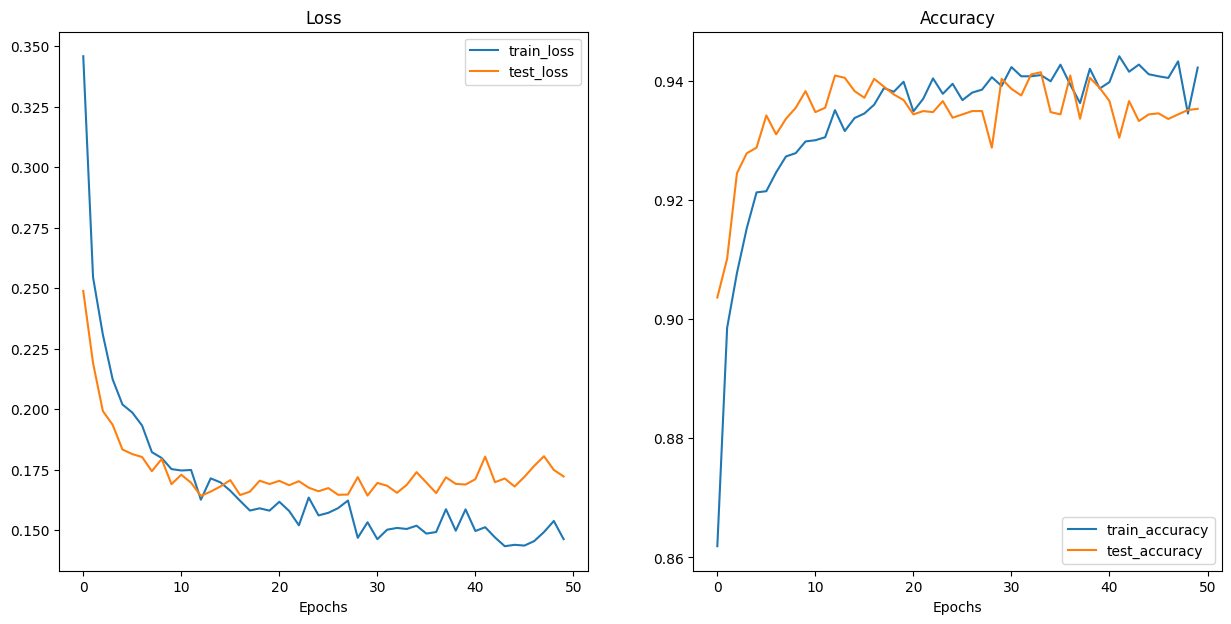

In [48]:
plot_loss_curves(model_results)

In [ ]:
# uncomment to use
# torch.save(model.state_dict(), "../models/model-run4.pth")

### run5

In [ ]:
next(model.parameters()).device

In [ ]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

lr= 0.0011
n_epochs = 50

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

config= {
    "model": "ResNet50-v0",
    "pretrained": "imagenet",
    "optimizer": "Adam",
    "learning_rate": lr,
    "epochs": n_epochs
}

model_results = train_wandb(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    wandb_run_name="ResNet50-v0-run5",
    loss_fn=loss_fn,
    n_epochs=n_epochs,
    wandb_project_name="anime-or-not",
    wandb_log=True,
    config=config
)

In [ ]:
plot_loss_curves(model_results)